# This Notebook Explores Computer Vision Using MNIST Dataset.

In [2]:
# Required libraries are loaded. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

import cv2

In [3]:
# Files to be used.
path = "../../../Data/digit-recognizer/"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


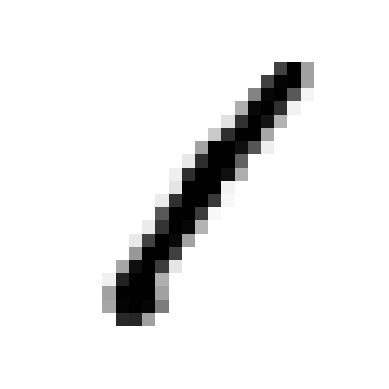

In [6]:
# Here we are visualizing a sample observation.
obs = train.iloc[0,][1:].to_numpy()
im = obs.reshape(28, 28)
plt.imshow(im, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
# Working with numpy is easier on sklearn.
X_train = train.loc[:,"pixel0":].to_numpy()
y_train = train.loc[:,"label"].to_numpy()
test = test.to_numpy()

### Grid Search KNeighbors for best parameter space.

In [9]:
# knn_clf = KNeighborsClassifier()

In [10]:
# Parameters to search for the best model.
# params = [{"n_neighbors": [2, 3, 4, 6], "weights": ["distance", "uniform"]}]

In [11]:
# grid_search = GridSearchCV(knn_clf, params, cv=5, scoring="accuracy", verbose=3)
# grid_search.fit(X_train, y_train)

In [12]:
# cvres = grid_search.cv_results_
 
# for mean_test_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(f"The mean_test_score is: {mean_test_score} and params: {params}")

### Grid Search SVM for best parameter space.

In [14]:
# {"kernel": ["poly"], "degree": [3, 4, 5], "C": [3, 4, 5], "coef0": [1, 2, 3]},
params_svm = [{"dual": [False, True], "loss": ["hinge"], "C": [3, 4, 5]}]

In [15]:
svm_clf_pipeline = Pipeline([("poly_features", PolynomialFeatures(degree=4)),
                             ("scaler", StandardScaler()), 
                             ("linear_svc", LinearSVC())
                            ])

In [ ]:
grid_search_lin_svm = GridSearchCV(svm_clf_pipeline["linear_svc"], params_svm, scoring="accuracy", cv=3, verbose=True)
grid_search_lin_svm.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [ ]:
cvres = grid_search_lin_svm.cv_results_

for mean_test_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f"The mean_test_score is: {mean_test_score} and params: {params}")

### Error Analysis

In [ ]:
y_train_pred = cross_val_predict(grid_search_lin_svm.best_estimator_, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

Let's visualize the above matrix

In [ ]:
plt.matshow(conf_mx, cmap="gray")
plt.show()

The image shows that the classifier did a good job classifying the digits. However, let's focus on the errors.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
norm_conf_mx

In [ ]:
np.fill_diagonal(norm_conf_mx, 0) # This elliminates correctly classified digits

In [ ]:
plt.matshow(norm_conf_mx, cmap="gray")
plt.show()

### Data Augmentation

In [ ]:
from scipy.ndimage import shift

In [ ]:
def shift_image(image, dx, dy):
    """
    This function is used to shift an image down, up, left and right.
    """
    
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dx, dy], cval=0)
    shifted_image = shifted_image.reshape([-1])
    return shifted_image

In [ ]:
def augment_data(predictors, labels):
    """
    This function augments both the predictors and labels.
    """
    augmented_predictors = [image for image in predictors]
    augmented_labels = [label for label in labels]
    
    rotations = [(1,0),(-1,0),(0,-1),(0,1)]
    for dx, dy in rotations:
        for image, label in zip(predictors, labels):
            shifted_image = shift_image(image, dx, dy)
            augmented_predictors.append(shifted_image)
            augmented_labels.append(label)
    augmented_predictors = np.array(augmented_predictors)
    augmented_labels = np.array(augmented_labels)
    return augmented_predictors, augmented_labels
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

### Additional Preprocessing

Will pause on scaling the data as it seems to cause a decline in performance for knn.

In [ ]:
# Standardize the training set.
# scaler = StandardScaler()
# X_train_augmented_scaled = scaler.fit_transform(X_train_augmented)
# test_scaled = scaler.fit_transform(test)

### Train KNeighbors on best parameters and augmented data.

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search_lin_svm.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)
predictions = knn_clf.predict(test)

In [ ]:
#scores = cross_val_score(knn_clf, X_train_augmented_scaled, y_train_augmented, cv=5)
#print(np.mean(scores))

In [ ]:
df = pd.DataFrame()
df["ImageId"] = np.arange(1, 28001)
df["Label"] = predictions
df.to_csv("kneighbors_predictions.csv", index=False)